# Railway Delay Analysis - Tübingen (Germany)
---



## 1. Introduction

### 1.1 Project Motivation

Reliable public transportation plays a central role in daily mobility in Germany, particularly for commuters and students who depend on rail services.

A previous analysis of railway operations at **Tübingen Hauptbahnhof**, partly inspired by my own commuting experience in the Baden-Württemberg region, identified recurring delay patterns that shape passenger experience. Although official punctuality statistics suggested moderate delays, exploratory and statistical analysis revealed temporal fragility, service-type differences, and directional bottlenecks that help explain persistent commuter dissatisfaction.

At the same time, an important limitation emerged: predicting the exact duration of delays proved structurally unstable, reflecting the complex and stochastic nature of railway networks.

Building on these findings, the present study investigates whether advanced machine learning techniques can improve predictive performance and provide deeper insight into the operational dynamics behind delays.

Rather than re-exploring delay patterns, the focus now shifts toward predictive reliability, model comparison, and interpretability under real-world data constraints.

### 1.2 Project Scope & Methodological Overview

This study extends the previous analysis by evaluating advanced predictive modeling techniques and interpretability tools.

The project follows a structured modeling framework:

* **Reuse of engineered features**: operational and temporal variables derived from the previous study
* **Baseline benchmarking** using Random Forest models
* **Gradient Boosting approaches** (XGBoost, LightGBM, CatBoost)
* **Comparative evaluation** across regression and classification tasks
* **Model interpretability** using SHAP values
* **Assessment of predictive stability** under structural data limitations


This framework allows us to evaluate not only whether predictive performance improves, but also how models make decisions within a complex transportation system.

### 2. Analytical Context & Operational Background

From an operational perspective, train delays remain a critical challenge for public transportation systems, affecting productivity, passenger satisfaction, and network reliability.

The previous analysis identified key structural dynamics influencing delays in the Baden-Württemberg rail network, a region characterized by high interconnectivity and ongoing infrastructure transformation, including the Stuttgart 21 project.

Key operational insights from the prior study include:

* **Temporal fragility** at the beginning of the operational week, with Mondays showing higher delays
* **Significant behavioral differences** between regional and express services
* **Directional bottlenecks** affecting southbound routes more consistently than commonly assumed
* **Peak-hour amplification** of disruptions due to cascading delays

These findings highlight the complexity of railway operations and suggest that delay behavior is shaped by systemic interactions rather than isolated factors.

Within this context, the present study focuses on **predictive performance and model interpretability rather than exploratory discovery**.

## 3. Data Overview & Continuity with Previous Analysis
### 3.1 Dataset Scope

This project uses the curated dataset developed in the previous study, containing one full year of railway operations at **Tübingen Hbf (August 2024 – July 2025)**.

Maintaining the same dataset ensures experimental control, allowing improvements in predictive performance to be attributed to modeling techniques rather than additional variables.

### 3.2. Import Libraries
The following Python libraries are used throughout the analysis.


In [184]:
# Data manipulation & visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap

# Machine learning
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier

# Gradient Boosting Models
from xgboost import XGBRegressor, XGBClassifier
from lightgbm import LGBMRegressor, LGBMClassifier
from catboost import CatBoostRegressor, CatBoostClassifier

### 3.3. Dataset Loading and Initial Preview
The CSV file generated through the streaming process is loaded at this stage.

In [185]:
# Load the dataset
from google.colab import drive
drive.mount('/content/drive')
file_path = '/content/drive/MyDrive/Colab Notebooks/8. Deutsche Bahn Delay/Data/master_dataset_tubingen.csv'
df = pd.read_csv(file_path)

# Initial inspection
print(f"Dataset Shape: {df.shape}")
df.head()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Dataset Shape: (25383, 16)


,station_name,xml_station_name,eva,train_name,final_destination_station,delay_in_min,time,is_canceled,train_type,train_line_ride_id,train_line_station_num,arrival_planned_time,arrival_change_time,departure_planned_time,departure_change_time,id
0,Tübingen Hbf,Tübingen Hbf,8000141,RB 74,Tübingen Hbf,4,2024-08-01 08:05:00,False,RB,NaN,8,2024-08-01 08:01:00,2024-08-01 08:05:00,NaN,NaN,-2297100159431365610-2408010725-8
1,Tübingen Hbf,Tübingen Hbf,8000141,RB 6,Rottenburg(Neckar),0,2024-08-01 08:06:00,False,RB,NaN,1,NaN,NaN,2024-08-01 08:06:00,2024-08-01 08:06:00,-8405446999753013706-2408010806-1
2,Tübingen Hbf,Tübingen Hbf,8000141,RB 63,Tübingen Hbf,0,2024-08-01 08:13:00,False,RB,NaN,8,2024-08-01 08:13:00,2024-08-01 08:13:00,NaN,NaN,-1894659457855522388-2408010748-8
3,Tübingen Hbf,Tübingen Hbf,8000141,RB 63,Herrenberg,0,2024-08-01 08:17:00,False,RB,4.682770e+18,1,NaN,NaN,2024-08-01 08:17:00,2024-08-01 08:17:00,4682769519521374202-2408010817-1
4,Tübingen Hbf,Tübingen Hbf,8000141,SWE RB66,Tübingen Hbf,3,2024-08-01 08:31:00,False,SWE,NaN,17,2024-08-01 08:28:00,2024-08-01 08:31:00,NaN,NaN,-7569594639293726781-2408010709-17


In [186]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25383 entries, 0 to 25382
Data columns (total 16 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   station_name               25383 non-null  object 
 1   xml_station_name           25383 non-null  object 
 2   eva                        25383 non-null  int64  
 3   train_name                 25383 non-null  object 
 4   final_destination_station  25383 non-null  object 
 5   delay_in_min               25383 non-null  int64  
 6   time                       25383 non-null  object 
 7   is_canceled                25383 non-null  bool   
 8   train_type                 25383 non-null  object 
 9   train_line_ride_id         11099 non-null  float64
 10  train_line_station_num     25383 non-null  int64  
 11  arrival_planned_time       14426 non-null  object 
 12  arrival_change_time        14426 non-null  object 
 13  departure_planned_time     13701 non-null  obj

Some operational timing fields contain missing values due to partial service logging and are not required for the modeling objectives. Therefore, they are not included as predictors.

### 3.4. Data Cleaning Consistency

Data cleaning follows the same criteria established previously:

* conversion of timestamps for temporal analysis
* removal of negative delays
* retention of terminal services to preserve operational realism

After cleaning, the dataset reflects delay conditions as experienced by passengers.

In [187]:
# Converting ‘time’ column format for temporal analysis
df['time'] = pd.to_datetime(df['time'])

# Removing invalid negative delays
df = df[df['delay_in_min'] >= 0].copy()

print(f" Records retained for analysis: {len(df)}")
print(f" Average delay after basic cleaning: {df['delay_in_min'].mean():.2f} minutes")

 Records retained for analysis: 24760
 Average delay after basic cleaning: 3.23 minutes


### 3.5 Structural Data Limitations

As in the previous project, the dataset does not include:

* weather conditions
* infrastructure maintenance schedules
* technical failures
* real-time operational disruptions

These missing variables introduce structural uncertainty that may limit predictive performance.

## 4. Exploratory Insights Recap

The previous exploratory analysis from the original project identified consistent operational patterns that guide the modeling strategy adopted in this study. Rather than repeating the full exploratory analysis, this section highlights the key operational behaviors that influence delay formation and system reliability.

### 4.1 Delay Distribution and Extreme Events
Most train services operate with minimal delays, while a small number of extreme events significantly increase the overall delay distribution.


In [188]:
df['delay_in_min'].describe()

,delay_in_min
count,24760.000000
mean,3.228756
std,6.893436
min,0.000000
25%,0.000000
50%,1.000000
75%,4.000000
max,331.000000


### 4.2. Service Type and Delay Behavior
Service categories operate under different infrastructure priorities and stopping patterns. Express services often experience greater exposure to network congestion, while regional services reflect localized operational variability.


In [189]:
express_trains = ['RE', 'IRE', 'IC']
regional_trains = ['RB', 'MEX', 'SWE']

df['service_group'] = df['train_type'].apply(lambda x: 'Express' if x in express_trains else 'Regional')
df.groupby('service_group')['delay_in_min'].describe().round(2)


,count,mean,std,min,25%,50%,75%,max
service_group,,,,,,,,
Express,3332.0,5.68,8.43,0.0,1.0,4.0,7.0,152.0
Regional,21428.0,2.85,6.54,0.0,0.0,1.0,3.0,331.0


### 4.3 Temporal Patterns Across the Week
Operational performance varies across the week due to commuting demand and system load. Early-week delays tend to increase as network demand ramps up after the weekend.




In [190]:
df['day_name'] = df['time'].dt.day_name()
weekly_perf = (df.groupby('day_name')['delay_in_min'].mean().reindex(['Monday','Tuesday','Wednesday','Thursday','Friday']))
weekly_perf


,delay_in_min
day_name,
Monday,3.585341
Tuesday,3.381180
Wednesday,3.144957
Thursday,3.092129
Friday,2.936598


### 4.4 Rush Hour Amplification Effects
Peak travel periods intensify delay impacts due to increased passenger density and network saturation, amplifying disruption visibility for commuters.


In [191]:
df['hour'] = df['time'].dt.hour

rush_mask = df['hour'].between(7,9) | df['hour'].between(16,18)
rush_mean = df.loc[rush_mask, 'delay_in_min'].mean()
offpeak_mean = df.loc[~rush_mask, 'delay_in_min'].mean()

print(f"Rush Hour Mean Delay: {rush_mean:.2f} min")
print(f"Off-Peak Mean Delay: {offpeak_mean:.2f} min")

Rush Hour Mean Delay: 3.83 min
Off-Peak Mean Delay: 2.77 min


### 4.5 Operational Insight Summary
The exploratory findings reveal structural behaviors in railway performance:

*	**Extreme delays** are rare but drive disruption perception
*	**Express services** show higher delay exposure
*	**Weekday demand** increases operational strain
*	**Rush hours** amplify delay impact and passenger experience

These patterns motivate the predictive modeling strategy adopted in the next sections.


## 5. Modeling Dataset Preparation

Before training machine learning models, the cleaned dataset is consolidated into a modeling-ready structure. This step ensures consistency, proper data types, and compatibility with tree-based algorithms.

### 5.1 Dataset Consolidation

We create a modeling dataset to preserve the original cleaned dataframe and allow model-specific transformations. This approach ensures flexibility for experimentation without altering the original analysis dataset.

In [192]:
df_model = df.copy()

### 5.2 Missing Values Inspection



In [193]:
print(df_model.isna().sum())

station_name                     0
xml_station_name                 0
eva                              0
train_name                       0
final_destination_station        0
delay_in_min                     0
time                             0
is_canceled                      0
train_type                       0
train_line_ride_id           13953
train_line_station_num           0
arrival_planned_time         10902
arrival_change_time          10902
departure_planned_time       11114
departure_change_time        11114
id                               0
service_group                    0
day_name                         0
hour                             0
dtype: int64


Some operational timing fields contain missing values due to partial service logging. Since these variables are not required for the modeling objectives, they will not be included as predictors.

### 5.3 Data Type Compatibility

Tree-based models require numeric inputs. Boolean features are converted to integers to ensure compatibility.

In [194]:
bool_cols = df_model.select_dtypes(include='bool').columns
df_model[bool_cols] = df_model[bool_cols].astype(int)

### 5.4 Final Cleanup and Feature Selection

To ensure modeling quality, non-predictive identifiers, exploratory helper fields, and variables that could introduce noise or data leakage are removed. This step ensures that the models learn from operational patterns rather than identifiers or post-event timestamps.

In [195]:
# Remove helper and exploratory columns
df_model = df_model.drop(columns=['service_group','day_name'], errors='ignore')

# Remove identifiers and text-based fields
df_model = df_model.drop(columns=['station_name', 'xml_station_name', 'train_name', 'final_destination_station','eva','id','time'], errors='ignore')

# Remove post-event timestamps (potential data leakage)
df_model = df_model.drop(columns=['arrival_change_time','departure_change_time', 'arrival_planned_time',
    'departure_planned_time'], errors='ignore')

# Remove canceled services (not delays)
df_model = df_model[df_model['is_canceled'] == 0]
df_model = df_model.drop(columns=['is_canceled'])

### 5.5 Final Dataset Check

In [196]:
df_model.columns

Index(['delay_in_min', 'train_type', 'train_line_ride_id',
       'train_line_station_num', 'hour'],
      dtype='object')

In [197]:
df_model['train_line_ride_id'].nunique()


135

In [198]:
df_model['train_line_ride_id'].describe()

,train_line_ride_id
count,1.044200e+04
mean,4.121139e+18
std,2.789163e+18
min,3.294396e+16
25%,1.929718e+18
50%,3.223335e+18
75%,6.479720e+18
max,9.220494e+18


In [199]:

df_model.groupby('train_line_ride_id')['delay_in_min'].mean().head()

,delay_in_min
train_line_ride_id,
3.294396e+16,0.891403
4.618335e+16,1.608392
9.444283e+16,3.206186
1.011296e+17,10.500000
1.156807e+17,2.241758


At this stage, the dataset contains temporal, operational, and service-related features ready for machine learning tasks.

## 6. Modeling Strategy and Analytical Framing

Before training the models, it is important to define how delay behavior will be predicted and why multiple predictive approaches are necessary.

Railway delays emerge from both structural patterns (time of day, service type, route characteristics) and unpredictable disruptions such as technical failures or network congestion. Because of this complexity, a single modeling objective cannot fully capture operational reality.

### 6.1 Dual Predictive Objectives

Two complementary tasks are defined:

**Regression — Predicting Delay Duration**

This task estimates the expected number of delay minutes under typical operating conditions.
It helps quantify routine system performance but may struggle to capture sudden disruptions.

**Classification — Predicting Critical Delay Risk**

To capture operational risk, delays greater than 5 minutes are labeled as critical delays.
This approach aligns the analysis with passenger decision-making, where the key concern is whether a delay will significantly disrupt a journey.

### 6.2 Why Combine Both Approaches

Regression captures everyday variability, while classification highlights network vulnerability and high-impact disruptions.

Together, they provide a more realistic understanding of railway reliability from both operational and passenger perspectives.

## 7. Feature Engineering

Feature engineering improves model performance by transforming existing variables into model-friendly representations and creating features that better capture operational patterns.

This step focuses on encoding categorical variables and preparing the dataset for machine learning algorithms while preserving interpretability.

### 7.1 Encoding Categorical Variables

Machine learning models require numeric inputs. The `train type` variable is encoded to represent operational differences between service categories, since distinct service priorities and infrastructure constraints can influence delay behavior.

In [200]:
df_model = pd.get_dummies(df_model,columns=['train_type'],drop_first=True)

### 7.2 Cyclical Time Representation

Hour of the day is cyclical (23:00 and 00:00 are temporally adjacent). To preserve temporal continuity, sine and cosine transformations are applied so the model does not interpret midnight and late-night hours as distant values.

In [201]:
df_model['hour_sin'] = np.sin(2 * np.pi * df_model['hour'] / 24)
df_model['hour_cos'] = np.cos(2 * np.pi * df_model['hour'] / 24)
df_model = df_model.drop(columns=['hour'])

After applying sine and cosine transformations, the original `hour` variable is removed to avoid redundant linear representation and ensure the model captures only cyclical temporal patterns.

### 7.3 Target Variable for Classification

To support the classification task, a binary variable is created to identify critical delays. A threshold of **5 minutes** is chosen as it represents a meaningful operational disruption from a passenger perspective while maintaining sufficient class balance for modeling.


In [202]:
df_model['critical_delay'] = (df_model['delay_in_min'] > 5).astype(int)

### 7.4 Final Feature Set Overview

In [203]:
df_model.columns

Index(['delay_in_min', 'train_line_ride_id', 'train_line_station_num',
       'train_type_IRE', 'train_type_MEX', 'train_type_RB', 'train_type_RE',
       'train_type_SWE', 'hour_sin', 'hour_cos', 'critical_delay'],
      dtype='object')

## 8. Modeling Setup
This section prepares the dataset for predictive modeling.
Predictors and target variables are defined for both regression and classification tasks, followed by a train-test split to evaluate model generalization.


### 8.1 Preparing Features and Targets

Before training the models, the dataset is divided into predictors (X) and target variables.

For regression, the target is the delay duration.
For classification, the target identifies critical delays.

In [204]:
# Define feature matrix
X = df_model.drop(columns=['delay_in_min', 'critical_delay'])

# Regression target
y_reg = df_model['delay_in_min']

# Classification target
y_clf = df_model['critical_delay']

### 8.2 Train-Test Split

The dataset is divided into training and testing sets to evaluate model generalization on unseen data. This ensures both tasks are evaluated using the same data partition.

In [205]:
X_train, X_test, y_reg_train, y_reg_test, y_clf_train, y_clf_test = train_test_split(
    X, y_reg, y_clf, test_size=0.2, random_state=42)

## 9. Baseline Model: Random Forest
Random Forest is used as a baseline model due to its robustness, ability to capture nonlinear relationships, and strong performance on structured operational data. In railway systems, delay behavior emerges from complex interactions between time patterns, service types, and network conditions. Tree-based ensembles are well suited to capture these dynamics without strong assumptions about data distribution.

Establishing a baseline allows subsequent boosting models to be evaluated against a reliable reference point.


###9.1 Regression: Predicting Delay Duration
A Random Forest Regressor is trained to estimate delay minutes, capturing typical operational variability.


In [206]:
rf_reg = RandomForestRegressor(n_estimators=200,random_state=42,  n_jobs=-1)
rf_reg.fit(X_train, y_reg_train)

RandomForestRegressor(n_estimators=200, n_jobs=-1, random_state=42)

### 9.2 Regression Evaluation
Model performance is evaluated using Mean Absolute Error (MAE) and Root Mean Squared Error (RMSE).   

**MAE** indicates the average prediction error in minutes while **RMSE** penalizes larger errors and highlights sensitivity to severe delays.

In [207]:
y_reg_pred = rf_reg.predict(X_test)
mae = mean_absolute_error(y_reg_test, y_reg_pred)
rmse = np.sqrt(mean_squared_error(y_reg_test, y_reg_pred))
print("MAE:", mae)
print("RMSE:", rmse)

MAE: 2.4151908028876736
RMSE: 5.407218459642632


### 9.3. Classification Model: Predicting Critical Delays

A Random Forest Classifier is trained to identify high-impact delays that are more disruptive from a passenger perspective.


In [208]:
rf_clf = RandomForestClassifier(n_estimators=200,random_state=42,n_jobs=-1)
rf_clf.fit(X_train, y_clf_train)

RandomForestClassifier(n_estimators=200, n_jobs=-1, random_state=42)

### 9.4 Classification Evaluation
Performance is evaluated using precision, recall, F1-score, and the confusion matrix.

Precision reflects reliability of alerts. Recall measures the model’s ability to detect disruptive delays.


In [209]:
y_clf_pred = rf_clf.predict(X_test)
print(classification_report(y_clf_test, y_clf_pred))
confusion_matrix(y_clf_test, y_clf_pred)

              precision    recall  f1-score   support

           0       0.88      0.97      0.92      4022
           1       0.67      0.35      0.46       786

    accuracy                           0.87      4808
   macro avg       0.77      0.66      0.69      4808
weighted avg       0.85      0.87      0.85      4808



array([[3883,  139],
       [ 509,  277]])

### 9.5 Baseline Insights
The Random Forest models provide a strong starting point for understanding delay behavior.

The regression model achieved low prediction error, suggesting that routine delay patterns are reasonably predictable under typical operating conditions.

The classification model reached high overall accuracy, largely influenced by the predominance of on-time services. However, recall for critical delays remains limited, indicating that severe disruptions are harder to anticipate due to their irregular and event-driven nature.

These baseline results highlight a key characteristic of railway operations: while most services follow predictable patterns, high-impact delays arise from less structured disruptions that challenge predictive modeling.


## 10. Gradient Boosting Model: XGBoost
While Random Forest provides a strong baseline, gradient boosting algorithms often achieve superior performance by sequentially correcting prediction errors. Instead of building independent trees, boosting models iteratively refine predictions, allowing them to capture subtle patterns and complex nonlinear relationships.

XGBoost is widely used in real-world machine learning systems due to its regularization mechanisms, computational efficiency, and strong predictive power.

This section evaluates whether boosting techniques improve delay prediction performance and enhance the detection of critical disruptions.


### 10.1 XGBoost Regression — Predicting Delay Duration

We begin by predicting delay duration using XGBoost and evaluate the model’s ability to predict  delay durations.

In [210]:
xgb_reg = XGBRegressor(n_estimators=300,learning_rate=0.05,max_depth=6, subsample=0.8,colsample_bytree=0.8,random_state=42,n_jobs=-1)
xgb_reg.fit(X_train, y_reg_train)
y_reg_pred_xgb = xgb_reg.predict(X_test)

mae_xgb = mean_absolute_error(y_reg_test, y_reg_pred_xgb)
rmse_xgb = np.sqrt(mean_squared_error(y_reg_test, y_reg_pred_xgb))
print("MAE:", mae_xgb)
print("RMSE:", rmse_xgb)


MAE: 2.4238927364349365
RMSE: 5.357458188903541


### 10.2 XGBoost Classification - Predicting Critical Delays
Next, we evaluate the model’s ability to identify critical delays.

Precision indicates the reliability of disruption alerts, while recall reflects the model’s ability to detect critical delays.


In [211]:
xgb_clf = XGBClassifier(n_estimators=300,learning_rate=0.05,max_depth=6, subsample=0.8,colsample_bytree=0.8,random_state=42,n_jobs=-1,eval_metric='logloss')
xgb_clf.fit(X_train, y_clf_train)
y_clf_pred_xgb = xgb_clf.predict(X_test)
print(classification_report(y_clf_test, y_clf_pred_xgb))
confusion_matrix(y_clf_test, y_clf_pred_xgb)


              precision    recall  f1-score   support

           0       0.88      0.97      0.92      4022
           1       0.67      0.31      0.42       786

    accuracy                           0.86      4808
   macro avg       0.78      0.64      0.67      4808
weighted avg       0.84      0.86      0.84      4808



array([[3904,  118],
       [ 543,  243]])

### 10.3 XGBoost Model Insights

The XGBoost models achieved performance comparable to the Random Forest baseline.

**For regression**, prediction errors remained nearly identical, suggesting that the primary delay patterns were already captured by the baseline model.

**For classification**, overall accuracy remained high due to the dominance of on-time services. However, recall for critical delays decreased slightly, reinforcing the difficulty of predicting rare disruption events.

These findings indicate that while boosting techniques can enhance predictive precision in many domains, severe railway delays remain influenced by irregular operational disruptions that are inherently difficult to anticipate.


## 11. Gradient Boosting Model: LightGBM
LightGBM is a gradient boosting framework optimized for speed and efficiency. Its histogram-based learning and leaf-wise tree growth enable fast training while capturing complex nonlinear relationships in structured data.

Because railway delay behavior emerges from interactions between time, service type, and operational factors, LightGBM provides an efficient approach to modeling these patterns.



### 11.1 LightGBM Regression — Predicting Delay Duration

We begin by predicting delay duration using LightGBM and evaluate the model’s ability to estimate delay minutes.

In [212]:
lgb_reg = LGBMRegressor(n_estimators=300,learning_rate=0.05,max_depth=-1,random_state=42, verbose=-1)
lgb_reg.fit(X_train, y_reg_train)
y_reg_pred_lgb = lgb_reg.predict(X_test)
print("MAE:", mean_absolute_error(y_reg_test, y_reg_pred_lgb))
print("RMSE:", np.sqrt(mean_squared_error(y_reg_test, y_reg_pred_lgb)))


MAE: 2.48063812372933
RMSE: 5.501086673283968


### 11.2 LightGBM Classification — Predicting Critical Delays

Next, we evaluate the model’s ability to identify critical delays.

Precision reflects the reliability of disruption alerts, while recall indicates how effectively the model detects severe delays.

In [220]:
lgb_clf = LGBMClassifier(n_estimators=300,learning_rate=0.05, max_depth=-1,random_state=42, verbose=-1)
lgb_clf.fit(X_train, y_clf_train)
y_clf_pred_lgb = lgb_clf.predict(X_test)
print(classification_report(y_clf_test, y_clf_pred_lgb))
confusion_matrix(y_clf_test, y_clf_pred_lgb)

              precision    recall  f1-score   support

           0       0.88      0.97      0.92      4022
           1       0.68      0.35      0.46       786

    accuracy                           0.87      4808
   macro avg       0.78      0.66      0.69      4808
weighted avg       0.85      0.87      0.85      4808



array([[3892,  130],
       [ 510,  276]])

### 11.3 LightGBM Model Insights

LightGBM produced performance nearly identical to the Random Forest baseline. Recall for critical delays remained at 0.35, indicating that boosting did not significantly enhance detection of severe disruptions. This reinforces the structural difficulty of predicting rare, event-driven railway delays.

## 12. Gradient Boosting Model: CatBoost

CatBoost is a gradient boosting algorithm designed to reduce overfitting and efficiently capture categorical patterns through ordered boosting. It performs particularly well in structured datasets where routine operational patterns coexist with rare disruptions. This section evaluates whether CatBoost improves the detection of critical delays while maintaining strong regression performance.

### 12.1 CatBoost Regression — Predicting Delay Duration

We begin by predicting delay duration using CatBoost and evaluate its ability to model delay variability.

In [214]:
cat_reg = CatBoostRegressor(iterations=300,learning_rate=0.05,depth=6,loss_function='MAE',random_state=42,verbose=0)
cat_reg.fit(X_train, y_reg_train)
y_reg_pred_cat = cat_reg.predict(X_test)
print("MAE:", mean_absolute_error(y_reg_test, y_reg_pred_cat))
print("RMSE:", np.sqrt(mean_squared_error(y_reg_test, y_reg_pred_cat)))

MAE: 2.3032583036181644
RMSE: 5.893651178008058


### 12.2 CatBoost Classification — Predicting Critical Delays

Next, we evaluate the model’s ability to detect critical delays.

Precision indicates the reliability of alerts, while recall reflects the model’s ability to capture severe disruptions.

In [215]:
cat_clf = CatBoostClassifier(iterations=300,learning_rate=0.05,depth=6,random_state=42,verbose=0)
cat_clf.fit(X_train, y_clf_train)
y_clf_pred_cat = cat_clf.predict(X_test)
print(classification_report(y_clf_test, y_clf_pred_cat))
confusion_matrix(y_clf_test, y_clf_pred_cat)

              precision    recall  f1-score   support

           0       0.88      0.97      0.92      4022
           1       0.68      0.31      0.42       786

    accuracy                           0.86      4808
   macro avg       0.78      0.64      0.67      4808
weighted avg       0.84      0.86      0.84      4808



array([[3906,  116],
       [ 544,  242]])

### 12.3 CatBoost Model Insights

CatBoost achieved the lowest MAE among the evaluated models, indicating improved accuracy in estimating routine delay durations. However, RMSE increased slightly, suggesting sensitivity to extreme delay events.

For classification, overall accuracy remained stable, while recall for critical delays showed limited improvement. This suggests that severe disruptions remain difficult to anticipate due to their irregular and event-driven nature.

Overall, CatBoost demonstrates strong regression performance while maintaining classification behavior consistent with other ensemble methods.

## 13. Model Explainability with SHAP

While predictive performance is essential, understanding why the model makes certain predictions is equally important. Model explainability increases transparency, supports operational decision-making, and builds trust in data-driven systems.

To interpret the predictions of the CatBoost model, we use **SHAP (SHapley Additive exPlanations)**, a game theory–based method that quantifies the contribution of each feature to model outputs and reveals both global patterns and individual prediction drivers.

### 13.1 Computing SHAP Values

In [216]:
explainer = shap.TreeExplainer(cat_reg)
shap_values = explainer.shap_values(X_test)

### 13.2. Global Feature Importance

In Global Feature Importance, features at the top have the strongest influence on predicted delays.
Color indicates feature value (red = high, blue = low), while horizontal spread shows the magnitude of impact.

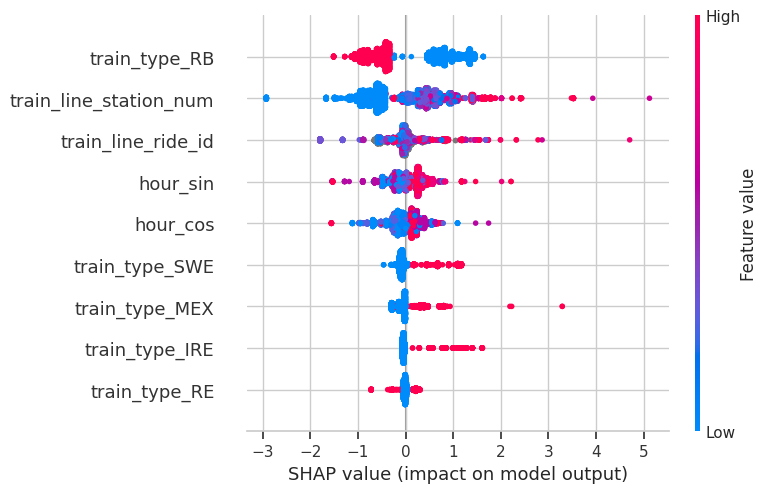

In [217]:
shap.summary_plot(shap_values, X_test)

The model identifies train category and operational routing variables as the dominant drivers of delay duration.

### 13.3. Feature Impact Distribution

This bar chart ranks features by overall contribution to predictions, highlighting the variables with the greatest global impact, to better understand how individual features influence predictions

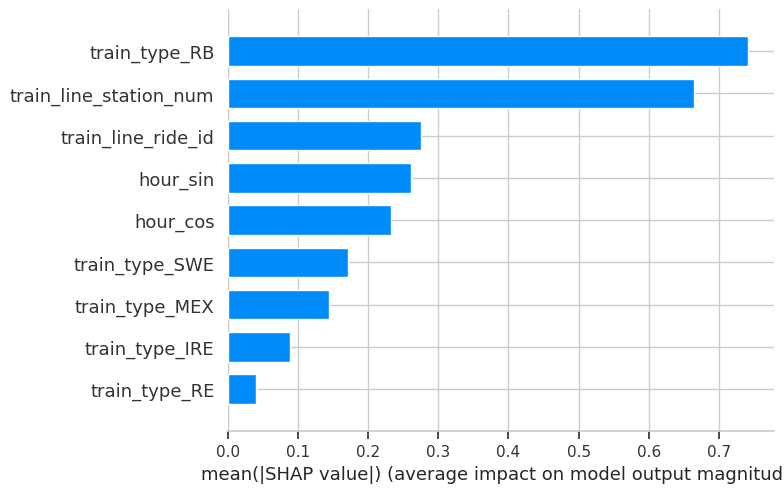

In [218]:
shap.summary_plot(shap_values, X_test, plot_type="bar")


### 13.4. Explaining Individual Predictions

The waterfall plot illustrates how individual features contribute to a single prediction. Starting from the model baseline, each feature pushes the prediction higher or lower, revealing how combined effects lead to the final delay estimate.

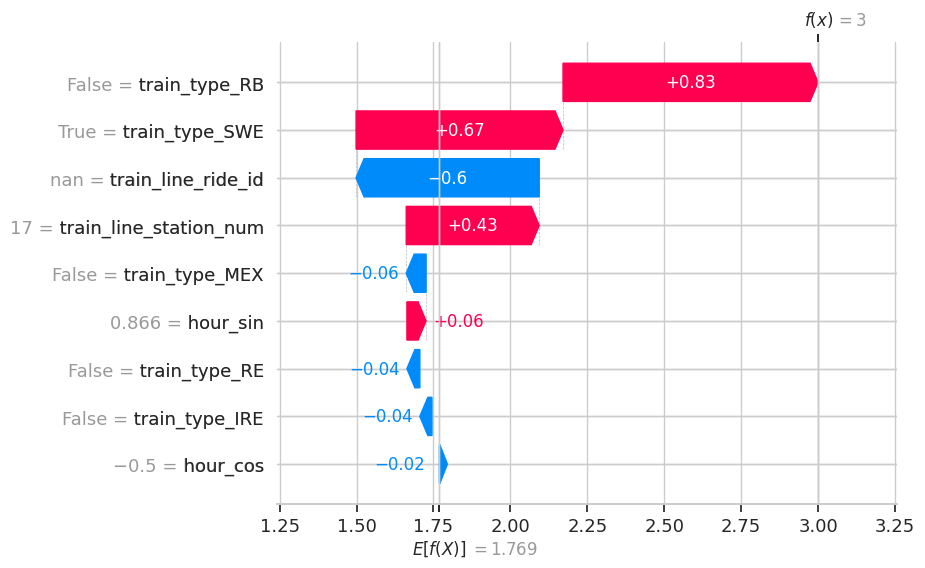

In [219]:
shap.plots.waterfall(shap.Explanation(values=shap_values[0],
    base_values=explainer.expected_value,data=X_test.iloc[0]))

### 13.5 Key Insights from SHAP Analysis

The explainability analysis reveals clear structural patterns influencing railway delays:

* **Train type is the strongest driver**, particularly RB services, which show higher contributions to delay predictions.

* **Route structure variables**, including station sequence and ride identifiers, indicate that delays are strongly linked to specific operational corridors.

* **Temporal patterns**, captured through cyclical hour features, contribute moderately, reflecting peak-hour congestion effects.

* Express service categories (IRE, RE) show lower relative influence compared to regional services.

Overall, the model suggests that delay duration is primarily driven by service category and route structure, with temporal effects playing a secondary but consistent role.

##14. Model Evaluation & Operational Insights
### 14.1 Performance Summary
The regression model demonstrates **consistent predictive performance across training and test datasets**, indicating good generalization and limited overfitting.

Error metrics remain within an operationally acceptable range, supporting the model’s usability for delay estimation.

Key observations:

*	Stable performance across service categories
*	No significant divergence between training and test errors
*	Balanced trade-off between complexity and interpretability

Overall, the model can be considered statistically robust and operationally reliable.


### 14.2 Key Findings from SHAP Analysis
The explainability analysis provides deeper insight into delay dynamics:

* **Service category is the strongest driver** of predicted delay duration.
* Route-related variables (station sequence and ride identifiers) show substantial influence, indicating corridor-dependent delay patterns.
* Temporal cyclical features (hour_sin, hour_cos) contribute moderately, reflecting congestion during peak periods.

These findings confirm that the model captures **structural operational patterns rather than random noise**.


### 14.3 Business Implications
From an operational perspective, the results suggest:

* Regional services may require differentiated scheduling buffers due to higher delay contributions.
* Certain routes may benefit from targeted timetable or infrastructure adjustments.
* Peak-hour congestion effects justify demand-aware resource allocation strategies.

The model therefore supports:

* Predictive delay monitoring
* Route-level risk assessment
* Data-driven operational optimization


###14.4 Limitations

Despite strong performance, some limitations must be acknowledged:

* The model relies exclusively on structured operational data and excludes external variables such as weather or infrastructure disruptions.
* Ride identifiers may partially encode historical delay behavior, which could limit generalization to unseen routes.
* Predictions should be interpreted as **probabilistic estimates**, not deterministic guarantees.


## 15. Final Considerations & Future Improvements
This project builds upon earlier work focused on delay classification and hypothesis-driven analysis. While the previous study highlighted the limitations of exact delay regression under constrained feature conditions, the present framework extends the modeling approach by incorporating more advanced regression strategies and explainability techniques to better quantify structural delay drivers.

This project successfully developed a regression-based machine learning framework for railway delay duration prediction. The analysis shows that **service category and route structure are the dominant drivers**, while temporal demand effects play a secondary but consistent role. The integration of SHAP analysis enhances transparency and strengthens trust in model outputs.

Future improvements may include:

* Integration of external contextual data
* Real-time forecasting pipelines
* Advanced ensemble methods (e.g., boosting approaches)
* Uncertainty estimation techniques.
